# K-Nearest Neighbor to Detect Distracted Driver

In [3]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import seaborn as sns
import pathlib
from sklearn.metrics import classification_report
from src.data.dataset_loader import load_distracted_driver_detection_list, load_dataset_image_label
from src.data.image_label_loader import ImageLabelLoader
from src.evaluation import metrics
from src.preprocessing.batch import tf_flatten
from src.utils.data_util import get_paths, sample_dataset
from src.classifiers.knn import KNearestNeighbor

# Auto reload external modules in ipython
#%load_ext autoreload
#%autoreload 2


# Load Train and Validation set

In [4]:
data_dir = pathlib.Path("dataset/raw/imgs/train") # Train directory

X_train_filenames, X_val_filenames, y_train_labels, y_val_labels = load_distracted_driver_detection_list(val_size=0.2, split_on_driver=True, random_state=12)
train_paths = get_paths(data_dir, X_train_filenames, y_train_labels)
val_paths = get_paths(data_dir, X_val_filenames, y_val_labels)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

num_train = len(train_paths)
num_val = len(val_paths)
num_classes = len(class_names)

print(f'Training set size: {num_train}')
print(f'Validation set size: {num_val}')
print(f'Number of classes: {num_classes}')


Training set size: 17761
Validation set size: 4663
Number of classes: 10


In [5]:
def preprocess(X_batch, y_batch):
    X_batch = tf_flatten(X_batch) # Flatten image to row
    return X_batch, y_batch

In [6]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train, train_dset
   del X_val, y_val, val_dset
   print('Clear previously loaded data.')
except:
   pass

CPU = '/cpu:0'
GPU = '/device:GPU:0'

batch_size = num_train # Load all to 1 batch
IMG_SHAPE = (64, 64, 3)
loader = ImageLabelLoader(class_names, img_shape=IMG_SHAPE)

# Force image load and preprocessing with specific device
with tf.device(CPU):
    # Train dataset input pipeline
    train_dset = tf.data.Dataset.from_tensor_slices(train_paths)
    train_dset = train_dset.map(loader.load, num_parallel_calls=tf.data.experimental.AUTOTUNE) # Load from path to image, label
    train_dset = train_dset.batch(batch_size, drop_remainder=False)
    train_dset = train_dset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dset = train_dset.cache()
    train_dset = train_dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    # Validation dataset input pipeline
    val_dset = tf.data.Dataset.from_tensor_slices(val_paths)
    val_dset = val_dset.map(loader.load, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dset = val_dset.batch(batch_size, drop_remainder=False)
    val_dset = val_dset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dset = val_dset.cache()
    val_dset = val_dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


X_train, y_train = next(iter(train_dset))
X_val, y_val = next(iter(val_dset))

X_train = X_train.numpy()
y_train = y_train.numpy()
X_val = X_val.numpy()
y_val = y_val.numpy()

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Training data shape:  (17761, 12288)
Training labels shape:  (17761,)
Validation data shape:  (4663, 12288)
Validation labels shape:  (4663,)


In [7]:
model = KNearestNeighbor()
model.train(X_train, y_train)

c:\Users\nicho\Documents\vscode_workspace\distracted-driver-detection\src\classifiers\knn.py:96: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(test_square + train_square - 2 * np.dot(X, self.X_train.T))


(4663, 17761)


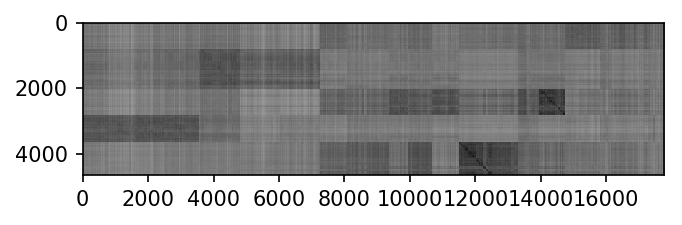

In [8]:
dists = model.vectorized_compute_distances(X_val)
print(dists.shape)

plt.figure(figsize=(5,2), dpi=150)
plt.imshow(dists, cmap='gray', interpolation='nearest')
plt.show()

In [36]:
# Searching for best K
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 25, 30, 40, 50, 100]

k_to_accuracies = {}
best_k = 0
best_accuracy = 0

for k in k_choices:
    y_val_pred = model.predict(X_val, k)
    acc = metrics.accuracy(y_val, y_val_pred)

    k_to_accuracies[k] = acc

    if acc > best_accuracy:
        best_accuracy = acc
        best_k = k


# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    print('k = %d, accuracy = %f' % (k, k_to_accuracies[k]))

c:\Users\nicho\Documents\vscode_workspace\distracted-driver-detection\src\classifiers\knn.py:96: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(test_square + train_square - 2 * np.dot(X, self.X_train.T))


k = 1, accuracy = 0.646794
k = 3, accuracy = 0.661591
k = 5, accuracy = 0.667382
k = 8, accuracy = 0.666095
k = 10, accuracy = 0.665880
k = 12, accuracy = 0.668025
k = 20, accuracy = 0.669741
k = 25, accuracy = 0.665880
k = 30, accuracy = 0.663092
k = 40, accuracy = 0.661377
k = 50, accuracy = 0.654085
k = 100, accuracy = 0.638859


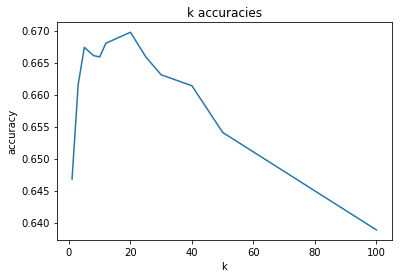

In [37]:
# Plot k accuracies
k_accuracies = np.array([v for k,v in sorted(k_to_accuracies.items())])
plt.plot(k_choices, k_accuracies)
plt.title('k accuracies')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

Best k = 20
Accuracy: 0.669741, 3123 / 4663
Confusion Matrix:
[[316.   3.   1.  42.  28.   0.  30.   0.  13.  30.]
 [  0. 318.   0.   4.  16.   0.  55.   2.  27.  48.]
 [  0.  55. 253.   0.  21.   0.  41.  11.  87.  31.]
 [  2.   0.  11. 358.  49.   0.   0.   0.  49.  21.]
 [ 10.   0.   0.  60. 419.   0.   0.   0.   6.   1.]
 [  4.   1.  28.   8.  46. 387.  11.   0.   2.  18.]
 [  0.  11.  58.   3.  34.   1. 368.   4.   4.   0.]
 [  1.   9.  10.  14.  16.   1.  25. 280.  39.   5.]
 [  9.  35.  39.  34.   1.   0.  31.   6. 236.  13.]
 [ 20. 105.   8.  53.  51.  15.   9.   0.   4. 188.]]
Confusion Matrix Heatmap:


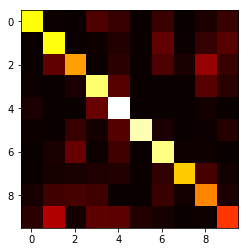

In [38]:
# Using Best k
print(f"Best k = {best_k}")
y_val_pred = model.predict_labels(dists, k=best_k)

# Print the fraction of correctly predicted examples
acc = metrics.accuracy(y_val, y_val_pred)
print('Accuracy: %f, %d / %d' % (acc, acc*num_val, num_val))

# Print confusion matrix
conf_matrix = metrics.confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Heatmap of the confusion matrix
print("Confusion Matrix Heatmap:")
plt.imshow(conf_matrix, cmap='hot', interpolation='nearest')
plt.show()

Best k = 15
Accuracy: 0.672528, 3136 / 4663


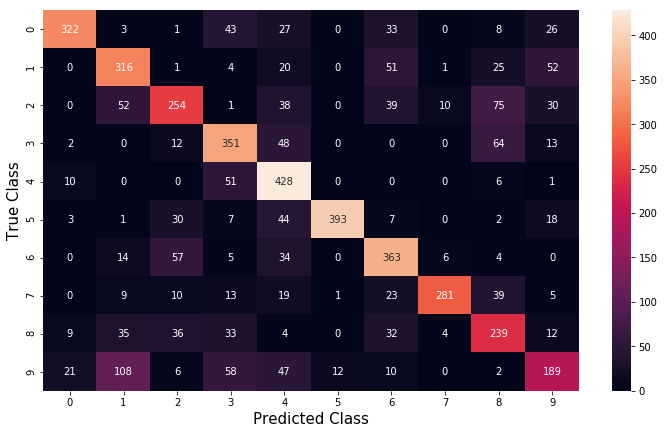

In [35]:
# Using Best k
print(f"Best k = {best_k}")
y_val_pred = model.predict_labels(dists, k=best_k)

# Print the fraction of correctly predicted examples
acc = metrics.accuracy(y_val, y_val_pred)
print('Accuracy: %f, %d / %d' % (acc, acc*num_val, num_val))

# Heat Map
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='g')
heatmap.set_xlabel("Predicted Class", fontsize = 15)
heatmap.set_ylabel("True Class", fontsize = 15)
plt.show()

In [40]:
class_desc = ['Safe Driving', 'Texting - Right', 'Talking on the phone - Right', 
'Texting - Left', 'Talking on the phone - Left', 'Operating The Radio', 
'Drinking', 'Reaching Behind', 'Hair and Makeup', 'Talking to Passanger']

print(classification_report(y_val, y_val_pred, target_names=class_desc))

                              precision    recall  f1-score   support

                Safe Driving       0.87      0.68      0.77       463
             Texting - Right       0.59      0.68      0.63       470
Talking on the phone - Right       0.62      0.51      0.56       499
              Texting - Left       0.62      0.73      0.67       490
 Talking on the phone - Left       0.62      0.84      0.71       496
         Operating The Radio       0.96      0.77      0.85       505
                    Drinking       0.65      0.76      0.70       483
             Reaching Behind       0.92      0.70      0.80       400
             Hair and Makeup       0.51      0.58      0.54       404
        Talking to Passanger       0.53      0.42      0.47       453

                    accuracy                           0.67      4663
                   macro avg       0.69      0.67      0.67      4663
                weighted avg       0.69      0.67      0.67      4663

